# Multi-step forecasting with feature engineering

In the previous notebook, we lined up most of the engineering steps into a Scikit-learn pipeline and then created all the features with one line of code. 

In this notebook, we'll use cross-validation with an expanding window to train a linear regression model that uses these new features as input to forecast pollutant concentrations for the following 24 hours.


## Data

We will work with the Air Quality Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 3, in the folder "01-Datasets" from this repo.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from feature_engine.creation import (
    CyclicalTransformer,
    MathematicalCombination,
)
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

# Load data

In [2]:
# We pack all data preparation steps from the
# previous notebook in a function.


def load_data():

    # Data lives here.
    filename = "../datasets/AirQualityUCI_ready.csv"

    # Load data: only the time variable and CO.
    data = pd.read_csv(
        filename,
        usecols=["Date_Time", "CO_sensor"],
        parse_dates=["Date_Time"],
        index_col=["Date_Time"],
    )

    # Sanity: sort index.
    data.sort_index(inplace=True)

    # Reduce data span.
    data = data["2004-04-01":"2005-04-30"]

    # Remove outliers
    data = data.loc[(data["CO_sensor"] > 0)]

    # Add timestamp as column
    data["Date_Time"] = data.index

    return data[["Date_Time", "CO_sensor"]]

In [3]:
# Load data.

data = load_data()

data.head()

,Date_Time,CO_sensor
Date_Time,,
2004-04-04 00:00:00,2004-04-04 00:00:00,1224.0
2004-04-04 01:00:00,2004-04-04 01:00:00,1215.0
2004-04-04 02:00:00,2004-04-04 02:00:00,1115.0
2004-04-04 03:00:00,2004-04-04 03:00:00,1124.0
2004-04-04 04:00:00,2004-04-04 04:00:00,1028.0


# Our feature engineering class

In [4]:
class SeasonalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, season_var, variables):

        # In the init we specify the parameters that
        # the user needs to pass to start the transformer.

        # The user needs to indicate the seasonal variable
        # and the variables that should be aggregated.

        self.season_var = season_var
        self.variables = variables

    def fit(self, X, y=None):

        # We want to estimate the mean value of the
        # time series in the seasonal term.

        # In our demo, that is the mean pollutant's
        # concentration per hour.

        # We make a copy of the dataframe
        # not to over-write the user's data.
        X = X.copy()

        # Calculate mean pollutant per hr.
        # The learned values will be stored in this attribute.
        self.seasonal_ = X.groupby(self.season_var)[self.variables].mean()

        # Rename the new variables.
        self.seasonal_.columns = [v + "_season" for v in self.variables]

        # Reset index
        self.seasonal_ = self.seasonal_.reset_index()

        return self

    def transform(self, X):

        # Add the seasonal component to the
        # dataset to transform.

        X = X.copy()

        # Store the datetime index (it is lost in merge)
        index = X.index

        # Add the seasonal feature.
        X = X.merge(self.seasonal_, on=self.season_var, how="left")

        # Restore the datetime index to the df
        X.index = index

        # Drop input variable
        X = X.drop(self.variables, axis=1)

        return X

# Feature engineering steps

The same pipeline from the previous notebook.

In [5]:
# Datetime features
dtf = DatetimeFeatures(
    # the input dt variable
    variables="Date_Time",
    # the features we want to create
    features_to_extract=[
        "month",
        "week",
        "day_of_week",
        "day_of_month",
        "hour",
        "weekend",
    ],
    # if we want to drop the dt column.
    drop_original=True,
)

In [6]:
# Lag features.

lagf = LagFeatures(
    variables="CO_sensor",  # the input variable
    freq=["1H", "24H"],  # move 1 hr forward
    missing_values="ignore",
)

In [7]:
# Window features

winf = WindowFeatures(
    variables="CO_sensor",  # the input variable
    window="3H",  # average of 3 previous hours
    freq="1H",  # move 1 hr forward
    missing_values="ignore",
)

In [8]:
# Feature combination

combine = MathematicalCombination(
    # the variables to combine
    variables_to_combine=["CO_sensor_lag_1H", "CO_sensor_lag_24H"],
    # we indicate we want the average
    math_operations=["mean"],
    # the name of the new feature
    new_variables_names=["CO_lag_ave"],
    # what to do if the variables have NA
    missing_values="ignore",
)

In [9]:
# Periodic features

cyclicf = CyclicalTransformer(
    # The features we want to transform.
    variables=["Date_Time_month", "Date_Time_hour"],
    # Whether to drop the original features.
    drop_original=False,
)

In [10]:
# Drop missing data
imputer = DropMissingData()

In [11]:
# Seasonal feature

seasonf = SeasonalTransformer(
    # the seasonal variable
    season_var="Date_Time_hour",
    # the time series
    variables=["CO_sensor"],
)

# Feature engineering pipeline

In [12]:
pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
        #     ("winf", winf),
        ("combine", combine),
        ("Periodic", cyclicf),
        ("dropna", imputer),
        ("seasonal", seasonf),
    ]
)

# Split data into train and test

We train the model on a training set and evaluate its performance on a test set. It is good practice to evaluate models on datasets that were not used for training.

In [13]:
# Split the data.

# input data
X_train = data[data.index < "2005-03-04"]
X_test = data[data.index >= "2005-03-04"]

# target
y_train = data[data.index < "2005-03-04"]["CO_sensor"]
y_test = data[data.index >= "2005-03-04"]["CO_sensor"]

In [14]:
# Create features

X_train_t = pipe.fit_transform(X_train)

X_train_t.head()

,Date_Time_month,Date_Time_week,Date_Time_day_of_week,Date_Time_day_of_month,Date_Time_hour,Date_Time_weekend,CO_sensor_lag_1H,CO_sensor_lag_24H,CO_lag_ave,Date_Time_month_sin,Date_Time_month_cos,Date_Time_hour_sin,Date_Time_hour_cos,CO_sensor_season
Date_Time,,,,,,,,,,,,,,
2004-04-05 00:00:00,4,15,0,5,0,0,1188.0,1224.0,1206.0,0.866025,-0.5,0.000000,1.000000,1039.513410
2004-04-05 01:00:00,4,15,0,5,1,0,1065.0,1215.0,1140.0,0.866025,-0.5,0.269797,0.962917,978.124528
2004-04-05 02:00:00,4,15,0,5,2,0,999.0,1115.0,1057.0,0.866025,-0.5,0.519584,0.854419,918.704120
2004-04-05 03:00:00,4,15,0,5,3,0,911.0,1124.0,1017.5,0.866025,-0.5,0.730836,0.682553,880.855019
2004-04-05 04:00:00,4,15,0,5,4,0,873.0,1028.0,950.5,0.866025,-0.5,0.887885,0.460065,864.211111


In [15]:
print(y_train.shape)

y_train_t = y_train.loc[X_train_t.index]

print(y_train_t.shape)

(6850,)
(6427,)


In [16]:
# Lasso regression

lasso = Lasso(random_state=0)

# Train the model

lasso.fit(X_train_t, y_train_t)

Lasso(random_state=0)

In [17]:
# Make predictions

preds = lasso.predict(X_train_t)

preds

array([1157.70888682, 1046.68548995,  974.58481358, ..., 1330.42267121,
       1238.46710384, 1166.42348376])

Text(0.5, 1.0, 'Forecast')

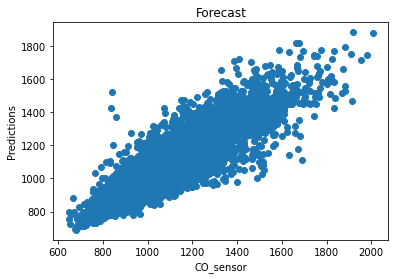

In [18]:
# Plot the predictions vs the truth.

plt.scatter(y_train_t, preds)
plt.xlabel("CO_sensor")
plt.ylabel("Predictions")
plt.title("Forecast")

We see that our linear regression makes fairly good predictions of the pollutant concentration in the next hour.

# Multi-step forecasting

To carry out multi-step forecasting, first we make the prediction for the following hour, and then we use that prediction value as a new feature to predict the concentration for the following hour, and so on.

## Forecasting 1 hour forward

In our training set, we've got data up to March 3rd at 23 hr. Let's use that data to forecast the pollutant concentration for March 4th at 00 hr.

In [19]:
# The last values in the train set.

mini_df = X_train.tail(24)

mini_df

,Date_Time,CO_sensor
Date_Time,,
2005-03-03 00:00:00,2005-03-03 00:00:00,1047.0
2005-03-03 01:00:00,2005-03-03 01:00:00,1030.0
2005-03-03 02:00:00,2005-03-03 02:00:00,986.0
2005-03-03 03:00:00,2005-03-03 03:00:00,992.0
2005-03-03 04:00:00,2005-03-03 04:00:00,1076.0
2005-03-03 05:00:00,2005-03-03 05:00:00,1104.0
2005-03-03 06:00:00,2005-03-03 06:00:00,1160.0
2005-03-03 07:00:00,2005-03-03 07:00:00,1217.0
2005-03-03 08:00:00,2005-03-03 08:00:00,1457.0


In [20]:
# Create a step forward.

step_dc = {
    "Date_Time": X_train.iloc[-1].name + pd.offsets.Hour(1),
    "CO_sensor": "NA",
}

step = pd.DataFrame(
    step_dc,
    index=[X_train.iloc[-1].name + pd.offsets.Hour(1)],
)

step

,Date_Time,CO_sensor
2005-03-04,2005-03-04,NA


In [21]:
# Add the step forward to the mini_df.

mini_df = mini_df.append(
    step,
    ignore_index=False,
    verify_integrity=True,
    sort=True,
)

mini_df

,CO_sensor,Date_Time
2005-03-03 00:00:00,1047.0,2005-03-03 00:00:00
2005-03-03 01:00:00,1030.0,2005-03-03 01:00:00
2005-03-03 02:00:00,986.0,2005-03-03 02:00:00
2005-03-03 03:00:00,992.0,2005-03-03 03:00:00
2005-03-03 04:00:00,1076.0,2005-03-03 04:00:00
2005-03-03 05:00:00,1104.0,2005-03-03 05:00:00
2005-03-03 06:00:00,1160.0,2005-03-03 06:00:00
2005-03-03 07:00:00,1217.0,2005-03-03 07:00:00
2005-03-03 08:00:00,1457.0,2005-03-03 08:00:00
2005-03-03 09:00:00,1337.0,2005-03-03 09:00:00


In [22]:
mini_df_t = pipe.transform(mini_df)

mini_df_t

,Date_Time_month,Date_Time_week,Date_Time_day_of_week,Date_Time_day_of_month,Date_Time_hour,Date_Time_weekend,CO_sensor_lag_1H,CO_sensor_lag_24H,CO_lag_ave,Date_Time_month_sin,Date_Time_month_cos,Date_Time_hour_sin,Date_Time_hour_cos,CO_sensor_season
2005-03-04,3,9,4,4,0,0,1179.0,1047.0,1113.0,1.0,6.123234e-17,0.0,1.0,1039.51341


In [23]:
# Forecast the pollutant concentration in the next
# hour.

pred = lasso.predict(mini_df_t)

pred

array([1132.97912894])

## Forecasting 2 hours forward

In [24]:
mini_df

,CO_sensor,Date_Time
2005-03-03 00:00:00,1047.0,2005-03-03 00:00:00
2005-03-03 01:00:00,1030.0,2005-03-03 01:00:00
2005-03-03 02:00:00,986.0,2005-03-03 02:00:00
2005-03-03 03:00:00,992.0,2005-03-03 03:00:00
2005-03-03 04:00:00,1076.0,2005-03-03 04:00:00
2005-03-03 05:00:00,1104.0,2005-03-03 05:00:00
2005-03-03 06:00:00,1160.0,2005-03-03 06:00:00
2005-03-03 07:00:00,1217.0,2005-03-03 07:00:00
2005-03-03 08:00:00,1457.0,2005-03-03 08:00:00
2005-03-03 09:00:00,1337.0,2005-03-03 09:00:00


In [25]:
mini_df.loc[mini_df["CO_sensor"] == "NA", "CO_sensor"] = pred[0]

mini_df

,CO_sensor,Date_Time
2005-03-03 00:00:00,1047.000000,2005-03-03 00:00:00
2005-03-03 01:00:00,1030.000000,2005-03-03 01:00:00
2005-03-03 02:00:00,986.000000,2005-03-03 02:00:00
2005-03-03 03:00:00,992.000000,2005-03-03 03:00:00
2005-03-03 04:00:00,1076.000000,2005-03-03 04:00:00
2005-03-03 05:00:00,1104.000000,2005-03-03 05:00:00
2005-03-03 06:00:00,1160.000000,2005-03-03 06:00:00
2005-03-03 07:00:00,1217.000000,2005-03-03 07:00:00
2005-03-03 08:00:00,1457.000000,2005-03-03 08:00:00
2005-03-03 09:00:00,1337.000000,2005-03-03 09:00:00


In [26]:
# Create the next step

step_dc = {
    "Date_Time": mini_df.iloc[-1].name + pd.offsets.Hour(1),
    "CO_sensor": "NA",
}

step = pd.DataFrame(
    step_dc,
    index=[mini_df.iloc[-1].name + pd.offsets.Hour(1)],
)

step

,Date_Time,CO_sensor
2005-03-04 01:00:00,2005-03-04 01:00:00,NA


In [27]:
# Append the next step

mini_df = mini_df.append(
    step,
    ignore_index=False,
    verify_integrity=True,
    sort=True,
)

mini_df

,CO_sensor,Date_Time
2005-03-03 00:00:00,1047.000000,2005-03-03 00:00:00
2005-03-03 01:00:00,1030.000000,2005-03-03 01:00:00
2005-03-03 02:00:00,986.000000,2005-03-03 02:00:00
2005-03-03 03:00:00,992.000000,2005-03-03 03:00:00
2005-03-03 04:00:00,1076.000000,2005-03-03 04:00:00
2005-03-03 05:00:00,1104.000000,2005-03-03 05:00:00
2005-03-03 06:00:00,1160.000000,2005-03-03 06:00:00
2005-03-03 07:00:00,1217.000000,2005-03-03 07:00:00
2005-03-03 08:00:00,1457.000000,2005-03-03 08:00:00
2005-03-03 09:00:00,1337.000000,2005-03-03 09:00:00


In [28]:
mini_df_t = pipe.transform(mini_df)

# Forecast the pollutant concentration in the next
# hour.

pred = lasso.predict(mini_df_t.tail(1))

pred

array([1082.32104353])

And we continue on an on. You get the gist.

## Forecasting 24 hours forward

Let's now streamline this procedure to forecast the next 24 hours of pollutant concentration.

Much of this code is the same that we described previously. We just put it in a loop.

In [29]:
# The last values in the train set.

mini_df = X_train.tail(24)

In [30]:
# Create a step forward.

step_dc = {
    "Date_Time": X_train.iloc[-1].name + pd.offsets.Hour(1),
    "CO_sensor": "NA",
}

step = pd.DataFrame(
    step_dc,
    index=[X_train.iloc[-1].name + pd.offsets.Hour(1)],
)

# Add the step forward to the mini_df.

mini_df = mini_df.append(
    step,
    ignore_index=False,
    verify_integrity=True,
    sort=True,
)

In [31]:
mini_df_t = pipe.transform(mini_df)

# Forecast the pollutant concentration in the next
# hour.

pred = lasso.predict(mini_df_t)

pred

array([1132.97912894])

In [32]:
# Now we use the prediction as input to make
# the prediction in the following hour.

# And we repeat the process 23 times:

for i in range(23):

    # Add the prediction to the df
    mini_df.loc[mini_df["CO_sensor"] == "NA", "CO_sensor"] = pred[0]

    # Add a step forward
    step_dc = {
        "Date_Time": mini_df.iloc[-1].name + pd.offsets.Hour(1),
        "CO_sensor": "NA",
    }

    step = pd.DataFrame(
        step_dc,
        index=[mini_df.iloc[-1].name + pd.offsets.Hour(1)],
    )

    # Append the next step
    mini_df = mini_df.append(
        step,
        ignore_index=False,
        verify_integrity=True,
        sort=True,
    )

    mini_df_t = pipe.transform(mini_df)

    # Forecast the pollutant concentration in the next
    # hour.

    pred = lasso.predict(mini_df_t.tail(1))

# Ad final prediction
mini_df.loc[mini_df["CO_sensor"] == "NA", "CO_sensor"] = pred[0]

# Our 24 hr forecast.
mini_df = mini_df[mini_df.index > X_train.iloc[-1].name]

mini_df = mini_df.drop(["Date_Time"], axis=1)

mini_df

,CO_sensor
2005-03-04 00:00:00,1132.979129
2005-03-04 01:00:00,1082.321044
2005-03-04 02:00:00,1026.725179
2005-03-04 03:00:00,977.407117
2005-03-04 04:00:00,944.872553
2005-03-04 05:00:00,927.912292
2005-03-04 06:00:00,941.687998
2005-03-04 07:00:00,1008.229664
2005-03-04 08:00:00,1109.981408
2005-03-04 09:00:00,1169.821556


In [33]:
# We can plot our predictions vs. the truth, which is
# the CO concentration in the test set.

tmp = mini_df.join(X_test["CO_sensor"], lsuffix="_left", rsuffix="_right")

tmp.columns = ["predicted", "actual"]

tmp

,predicted,actual
2005-03-04 00:00:00,1132.979129,929.0
2005-03-04 01:00:00,1082.321044,951.0
2005-03-04 02:00:00,1026.725179,938.0
2005-03-04 03:00:00,977.407117,921.0
2005-03-04 04:00:00,944.872553,850.0
2005-03-04 05:00:00,927.912292,811.0
2005-03-04 06:00:00,941.687998,848.0
2005-03-04 07:00:00,1008.229664,882.0
2005-03-04 08:00:00,1109.981408,936.0
2005-03-04 09:00:00,1169.821556,1022.0


Text(0, 0.5, 'CO concentration')

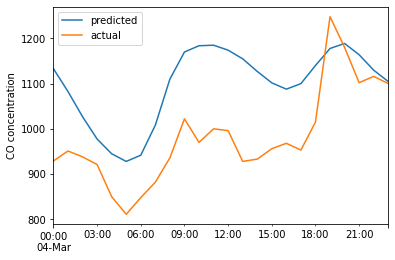

In [34]:
tmp.plot()
plt.ylabel("CO concentration")

Substantial improvement!

In [35]:
# And now we calculate the RMSE for the 24 hr.
# predictions.

print(
    "rmse: ",
    mean_squared_error(
        tmp["predicted"],
        tmp["actual"],
        squared=False,
    ),
)

rmse:  137.18647610999628


# Back-testing with expanding window

Now, we will make predictions with an expanding window. We will train the model up to a certain point, and then make predictions 24 hours ahead. We will then train the model up to a point further in the future, and make predictions 24 hours ahead. And so on.



<img src='../images/backtesting.png' width="600" height="600">


In [36]:
# Capture first day on test set

start = X_test.iloc[0].name
start

Timestamp('2005-03-04 00:00:00')

In [37]:
# Capture last day on test set

end = X_test.iloc[-1].name
end

Timestamp('2005-04-04 14:00:00')

In [38]:
# Create a 24 hr date range.

pd.date_range(start=start, end=end, freq="24H")

DatetimeIndex(['2005-03-04', '2005-03-05', '2005-03-06', '2005-03-07',
               '2005-03-08', '2005-03-09', '2005-03-10', '2005-03-11',
               '2005-03-12', '2005-03-13', '2005-03-14', '2005-03-15',
               '2005-03-16', '2005-03-17', '2005-03-18', '2005-03-19',
               '2005-03-20', '2005-03-21', '2005-03-22', '2005-03-23',
               '2005-03-24', '2005-03-25', '2005-03-26', '2005-03-27',
               '2005-03-28', '2005-03-29', '2005-03-30', '2005-03-31',
               '2005-04-01', '2005-04-02', '2005-04-03', '2005-04-04'],
              dtype='datetime64[ns]', freq='24H')

Our expanding windows correspond to adding 1 additional day of data to the train set.

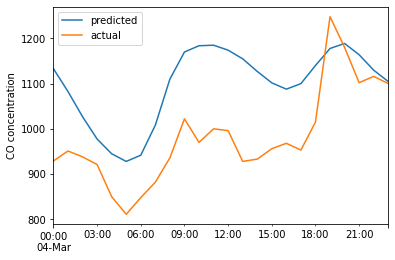

rmse:  137.18647610999628


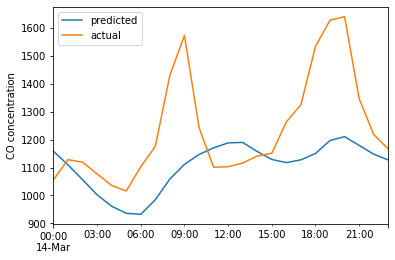

rmse:  212.5089970342394


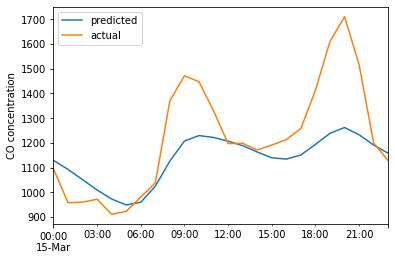

rmse:  172.0217940931809


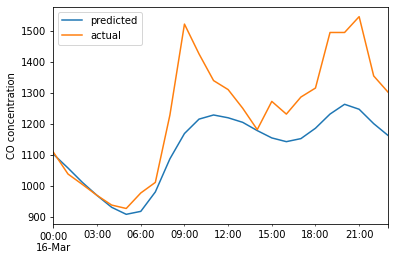

rmse:  148.23306295921276


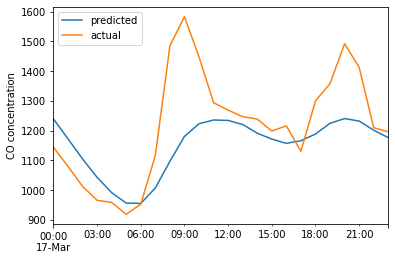

rmse:  151.2322779952831


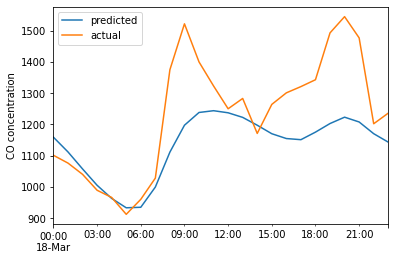

rmse:  154.99054195009958


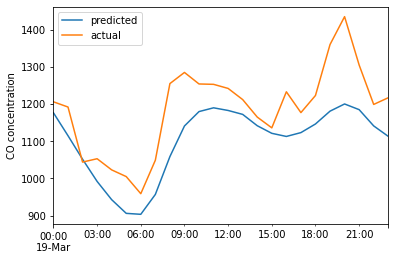

rmse:  102.43092150896379


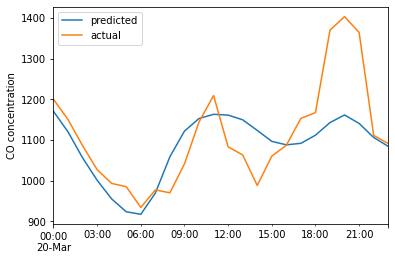

rmse:  96.98063699999953


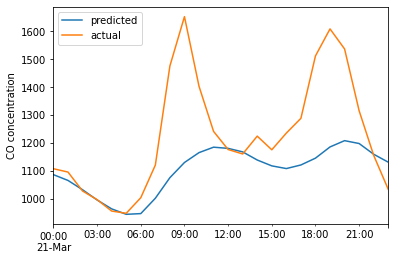

rmse:  205.6399424467394


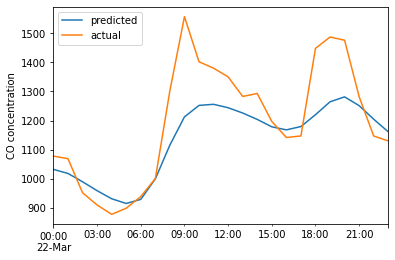

rmse:  124.51830550648766


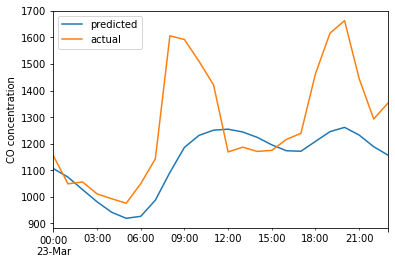

rmse:  210.54602616441164


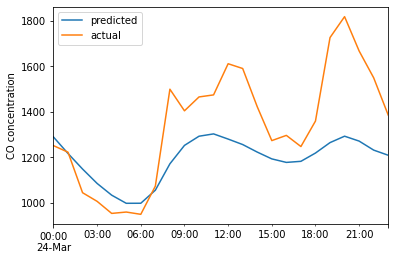

rmse:  233.02511338336748


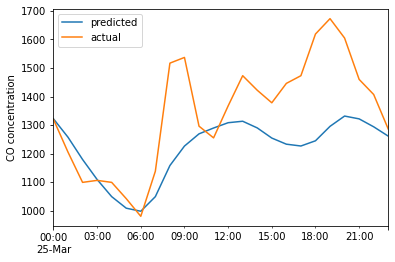

rmse:  183.29303463614752


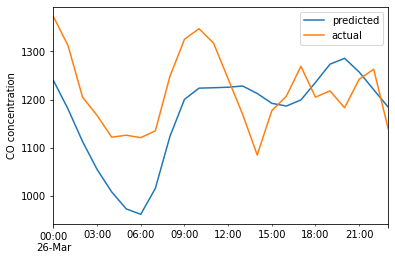

rmse:  98.03560998033535


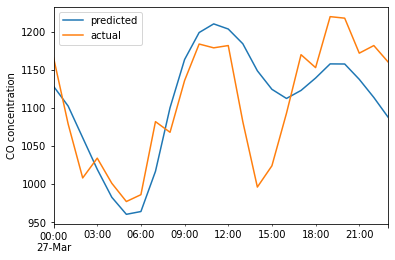

rmse:  57.430700768075084


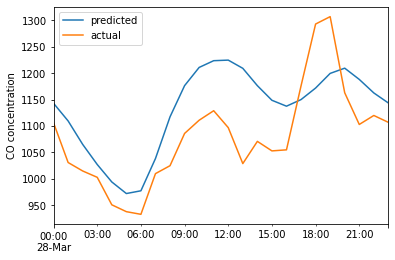

rmse:  83.55245820092603


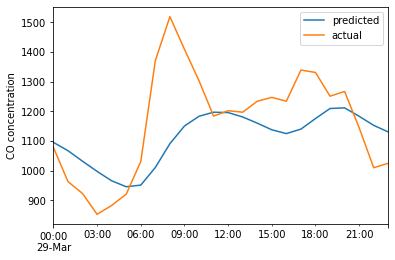

rmse:  155.84325590222636


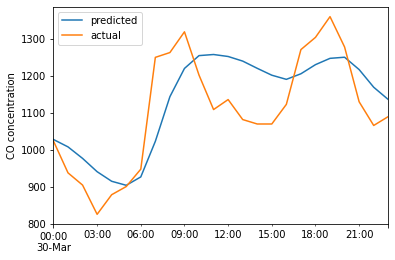

rmse:  102.47950822972234


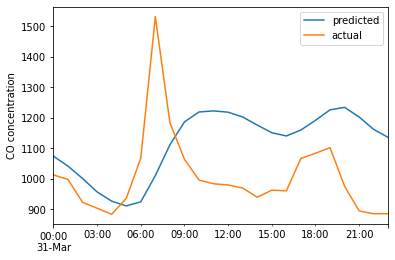

rmse:  204.5599246541034


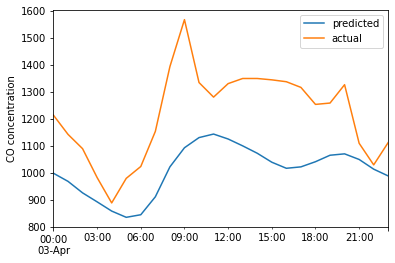

rmse:  230.8049246221121


In [41]:
# We collect the RMSE for each
# test set portion examined.
rmse_ls = []

# Now we loop, expanding the train set 24 hr.
# on each round

for date in pd.date_range(start=start, end=end, freq="24H"):

    # Split the data:
    # Here we perform the expanding window.
    X_train = data[data.index < date]
    X_test = data[data.index >= date]

    y_train = data[data.index < date]["CO_sensor"]

    # Fit feature engineering steps
    X_train_t = pipe.fit_transform(X_train)

    # Adjust y
    y_train_t = y_train.loc[X_train_t.index]

    # Fit regression model
    lasso.fit(X_train_t, y_train_t)

    # Forecast 1 hour forward:
    # ==========================

    # The last values in the train set.

    mini_df = X_train.tail(24)
    # Create a step forward.

    step_dc = {
        "Date_Time": X_train.iloc[-1].name + pd.offsets.Hour(1),
        "CO_sensor": "NA",
    }

    step = pd.DataFrame(
        step_dc,
        index=[X_train.iloc[-1].name + pd.offsets.Hour(1)],
    )

    # Add the step forward to the mini_df.

    mini_df = mini_df.append(
        step,
        ignore_index=False,
        verify_integrity=True,
        sort=True,
    )

    # Create features
    mini_df_t = pipe.transform(mini_df)

    # Forecast the pollutant concentration in the next
    # hour.

    pred = lasso.predict(mini_df_t)

    # Multistep forecast:
    # ====================

    # And we repeat the process 23 times:
    for i in range(23):

        # Add the prediction to the df
        mini_df.loc[mini_df["CO_sensor"] == "NA", "CO_sensor"] = pred[0]

        # Add a step forward
        step_dc = {
            "Date_Time": mini_df.iloc[-1].name + pd.offsets.Hour(1),
            "CO_sensor": "NA",
        }

        step = pd.DataFrame(
            step_dc,
            index=[mini_df.iloc[-1].name + pd.offsets.Hour(1)],
        )

        # Append the next step
        mini_df = mini_df.append(
            step,
            ignore_index=False,
            verify_integrity=True,
            sort=True,
        )

        mini_df_t = pipe.transform(mini_df)

        # Forecast the pollutant concentration in the next
        # hour.

        pred = lasso.predict(mini_df_t.tail(1))

    # Ad final prediction
    mini_df.loc[mini_df["CO_sensor"] == "NA", "CO_sensor"] = pred[0]

    # Our 24 hr forecast.
    mini_df = mini_df[mini_df.index > X_train.iloc[-1].name]

    mini_df = mini_df.drop(["Date_Time"], axis=1)

    mini_df

    # ==================================================
    # Remember that we do not have timestamps for every
    # hour in our test set (discussed in Section 2).

    # We will plot only those cases where we do have
    # the real values of the target.
    # ==================================================

    # Join predictions and real values.
    tmp = mini_df.join(X_test["CO_sensor"], lsuffix="_left", rsuffix="_right")

    # Rename columns in dataframe.
    tmp.columns = ["predicted", "actual"]

    # Check that we have all real values of
    # the actual time series.
    if not tmp["actual"].isnull().any():

        tmp.plot()
        plt.ylabel("CO concentration")
        plt.show()

        # Determine the RMSE.
        rmse_ = mean_squared_error(
            y_true=tmp["actual"],
            y_pred=tmp["predicted"],
            squared=False,
        )
        print("rmse: ", rmse_)

        # Append the RMSE to our list.
        rmse_ls.append(rmse_)

In [42]:
# Mean performance during cross-validation

print("rmse: ", np.mean(rmse_ls), "+-", np.std(rmse_ls))
print("Number of days evaluated: ", len(rmse_ls))

rmse:  153.2656756572815 +- 51.15779098925814
Number of days evaluated:  20


The performance in terms of the RMSE is somewhat similar to that obtain with the Linear regression using the lag feature as input. But by looking at the plots, we understand that this model follows more or less the ups and downs of the real concentration throughout the day (i.e., the seasonality), which the previous model could not do.


# Train final model

Now that we are happy with our model, we train it on the entire dataset and determine the feature importance.

In [43]:
# Load data.

data = load_data()

In [44]:
X_train = data.copy()
y_train = data["CO_sensor"].copy()

In [46]:
# Create the features

X_train = pipe.fit_transform(X_train)

y_train = y_train.loc[X_train.index]

In [47]:
# Fit the regression.
lasso.fit(X_train, y_train)

Lasso(random_state=0)

Text(0, 0.5, 'Importance')

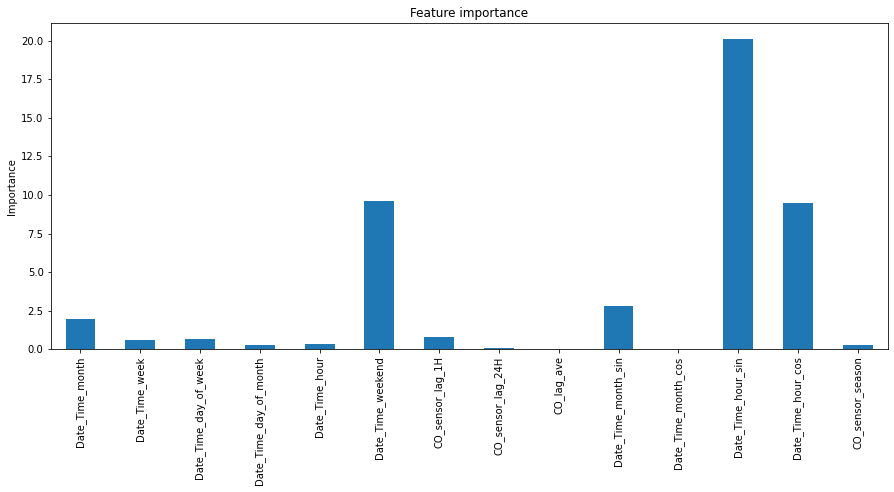

In [48]:
# Let's now plot the feature's importance

# The importance is stored in the estimator.
tmp = pd.Series(np.abs(lasso.coef_))

# Let's add the variable names.
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(15, 6))
plt.title("Feature importance")
plt.ylabel("Importance")

This model seems to capture the seasonality better because a lot of the time features contribute substantially to the prediction.